In [1]:
import sys

# Load diabetes dataset from sklearn
from sklearn.datasets import load_iris

import dc_check.logger as log
log.add(sink=sys.stderr, level="INFO")

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)
df = X.copy(deep=True)
df['target'] = y
display(df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:

from dc_check.plugins.core.datahandler import DataHandler
from dc_check.plugins.core.models.simple_mlp import SimpleMLP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

std_scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

datahander = DataHandler(X_train, y_train, batch_size=32)


model = SimpleMLP()
# creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [4]:
# dc_check absolute
from dc_check.plugins import Plugins

plugins = Plugins().list()
print(plugins)


['data_maps', 'large_loss', 'data_iq', 'conf_agree', 'aum', 'confident_learning', 'el2n', 'prototypicality', 'grand', 'forgetting', 'vog', 'allsh']


In [5]:
hcm = Plugins().get(
    "vog",
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    lr=learning_rate,
    epochs=10,
    total_samples=len(X_train),
    num_classes=3,
    logging_interval=1,
)
hcm.fit(
    datahandler=datahander,
    use_caches_if_exist=True,
)

[2023-07-10T17:23:15.852232+0100][624826][INFO] Fitting vog plugin
[2023-07-10T17:23:15.863206+0100][624826][INFO] Epoch 1/10: Loss=0.0000
[2023-07-10T17:23:16.011629+0100][624826][INFO] Epoch 2/10: Loss=0.0000
[2023-07-10T17:23:16.075163+0100][624826][INFO] Epoch 3/10: Loss=0.0000
[2023-07-10T17:23:16.119281+0100][624826][INFO] Epoch 4/10: Loss=0.0000
[2023-07-10T17:23:16.235126+0100][624826][INFO] Epoch 5/10: Loss=0.0000
[2023-07-10T17:23:16.297862+0100][624826][INFO] Epoch 6/10: Loss=0.0000
[2023-07-10T17:23:16.568445+0100][624826][INFO] Epoch 7/10: Loss=0.0000
[2023-07-10T17:23:16.985457+0100][624826][INFO] Epoch 8/10: Loss=0.0000
[2023-07-10T17:23:17.297038+0100][624826][INFO] Epoch 9/10: Loss=0.0000
[2023-07-10T17:23:17.553117+0100][624826][INFO] Epoch 10/10: Loss=0.0000


[2023-07-10T17:23:17.755424+0100][624826][INFO] Plotting vog scores


[0.15793634 0.02639368 0.01512812 0.04363953 0.48361972 0.12139836
 0.02028688 0.1636561  0.12159226 0.08152599 0.17907482 0.12095525
 0.35903113 0.08746851 0.03113733 0.47464132 0.03300495 0.08851621
 0.28955595 0.11054904 0.08732316 0.10462685 0.11638951 0.37683107
 0.0379062  0.44031654 0.26755291 0.23971847 0.4235813  0.15631278
 0.41314452 0.0694657  0.40557007 0.02752658 0.09446475 0.05273804
 0.02585173 0.02159104 0.01104899 0.08116616 0.29422977 0.15437969
 0.07970923 0.42903949 0.04805213 0.05463329 0.00724735 0.12883733
 0.32653396 0.42809852 0.0531872  0.42470325 0.07600109 0.39778554
 0.01097515 0.16344525 0.09778393 0.46813191 0.06011096 0.13387804
 0.29696921 0.17710607 0.04425593 0.19315618 0.03348069 0.04982092
 0.50163483 0.10199489 0.09367934 0.18222756 0.02461399 0.05968439
 0.08921966 0.15315529 0.37484757 0.05603443 0.35912151 0.32752296
 0.57347657 0.09974542 0.00854887 0.13075201 0.34281015 0.07879028
 0.08629468 0.33096534 0.20808117 0.2647204  0.09393094 0.3139

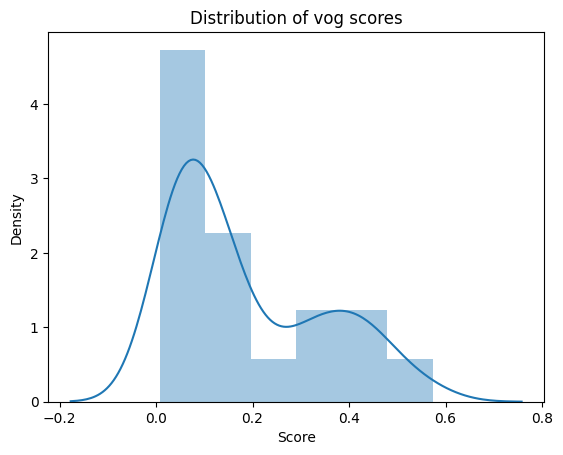

In [6]:
hcm_scores = hcm.scores
print(hcm_scores)
hcm.plot_scores()

In [7]:
import pandas as pd
print(hcm.name())
print(hcm.hard_direction())
hardest_5 = hcm.extract_datapoints(method="top_n", n=5)
display(pd.DataFrame(
    data={
        "indices":hardest_5[0][2],
        f"{X.columns[0]}": hardest_5[0][0].transpose(0,1)[0],
        f"{X.columns[1]}": hardest_5[0][0].transpose(0,1)[1],
        f"{X.columns[2]}": hardest_5[0][0].transpose(0,1)[2],
        f"{X.columns[3]}": hardest_5[0][0].transpose(0,1)[3],
        "labels": hardest_5[0][1],
        "scores": hardest_5[1]}))

vog
high


,indices,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),labels,scores
0,2,1.053005,-0.119255,0.950314,1.127075,2,0.015128
1,38,0.015440,-0.119255,0.727180,0.741436,2,0.011049
2,46,1.168290,0.341315,1.061882,1.384168,2,0.007247
3,54,0.361295,0.801885,0.894531,1.384168,2,0.010975
4,80,-0.791555,2.413881,-1.281031,-1.443850,0,0.008549
